In [1]:
import os, sys
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.metrics import smape, mape, mase, mse, rmse, r2_score, mae
from darts.dataprocessing.pipeline import Pipeline
from darts.utils.missing_values import extract_subseries
from sklearn.preprocessing import MinMaxScaler, RobustScaler   
from darts.dataprocessing.transformers.scaler import Scaler

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import h5py
import torch

from utils import *
import wandb
wandb.login()


import warnings
warnings.filterwarnings('ignore')

# Set seed
np.random.seed(42)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


In [2]:
# Set working directory
os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"
dir_path = os.path.join(os.getcwd(), 'data', 'clean_data')

Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\WattCast


In [3]:
# See what keys are in the directory

locations_per_file = {}
temporal_resolutions_per_file = {}

for file_name in os.listdir(dir_path):
    if file_name.endswith('.h5'):
        # open the file in read mode
        with h5py.File(os.path.join(dir_path, file_name), 'r') as f:
            # print the keys in the file
            locations = list(f.keys())
            locations_per_file[file_name] = locations
            for location in locations:
                temporal_resolutions = list(f[location].keys())
                temporal_resolutions_per_file[file_name] = temporal_resolutions

In [14]:
# run parameters


config_dataset = {
    'spatial_scale': '5_household',
    'temp_resolution': 60,
    'location': 'household_1',
}

config_modeldesign = {'boxcox': True,
                    'horizon_in_hours': 24, # in hours
                    'lookback_in_hours': 24, # in hours
                    'liklihood': None,
                    'weather': True,
                    'holiday': True,
                    'datetime_encodings': True,
                    }
                   

config_encoders =  {
                    "cyclic": {"future": ["hour"]}, 
                    "position": {"future": ["relative"]},
                    "datetime_attribute": { "future": ["dayofweek", "week"]},
                    }




In [15]:
# initialize wandb and log config
wandb.init(project="WattCast", config=config_dataset, name=config_dataset['spatial_scale']+ "_" + config_dataset['location'] + "_" + str(config_dataset['temp_resolution']) + "min")
config = wandb.config
config.update(config_modeldesign)
config.update(config_encoders)

In [18]:
# calculate derived parameters
datetime_encoders = config_encoders if config.datetime_encodings else None
timesteps_per_hour = int(60 / config.temp_resolution)
n_lags = config.lookback_in_hours * timesteps_per_hour
n_ahead = config.horizon_in_hours * timesteps_per_hour
list_metrics = [smape, mape, rmse, r2_score, mae] # evaluation metrics
eval_stride = n_ahead // 6 # prediction stride for evaluation
# Loading Data
df_train = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/train_target')
df_val = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/val_target')
df_test = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/test_target')

# Loading Covariates
if config.weather:
    df_cov_train = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/train_cov')
    df_cov_val = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/val_cov')
    df_cov_test = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/test_cov')

In [22]:
# into darts format
ts_train = darts.TimeSeries.from_dataframe(df_train, freq=str(config.temp_resolution) + 'min')
ts_train = extract_subseries(ts_train)
ts_val = darts.TimeSeries.from_dataframe(df_val, freq=str(config.temp_resolution) + 'min')
ts_val = extract_subseries(ts_val)
ts_test = darts.TimeSeries.from_dataframe(df_test, freq=str(config.temp_resolution) + 'min')
ts_test = extract_subseries(ts_test)

# Covariates
if config.weather:
    ts_cov_train = darts.TimeSeries.from_dataframe(df_cov_train, freq=str(config.temp_resolution) + 'min')
    ts_cov_val = darts.TimeSeries.from_dataframe(df_cov_val, freq=str(config.temp_resolution) + 'min')
    ts_cov_test = darts.TimeSeries.from_dataframe(df_cov_test, freq=str(config.temp_resolution) + 'min')
else:
    ts_cov_train = None
    ts_cov_val = None
    ts_cov_test = None

# Reviewing subseries to make sure they are long enough
ts_train, ts_cov_train = review_subseries(ts_train, n_lags, n_ahead, ts_cov_train)
ts_val, ts_cov_val = review_subseries(ts_val, n_lags, n_ahead, ts_cov_val)
ts_test, ts_cov_test = review_subseries(ts_test, n_lags, n_ahead, ts_cov_test)

# getting the index of the longest subseries, to be used for evaluation later
longest_ts_val_idx = get_longest_subseries_idx(ts_val)
longest_ts_test_idx = get_longest_subseries_idx(ts_test)



In [23]:
# Load pipeline
pipeline = Pipeline(
                    [
                    BoxCox() if config.boxcox else Scaler(MinMaxScaler()),
                    Scaler(MinMaxScaler()),
                    ]
                     )

ts_train_piped = pipeline.fit_transform(ts_train)
ts_val_piped = pipeline.transform(ts_val)
ts_test_piped = pipeline.transform(ts_test)

# Weather Pipeline
if config.weather:
    pipeline_weather = Pipeline([Scaler(RobustScaler())])
    ts_train_weather_piped = pipeline_weather.fit_transform(ts_cov_train)
    ts_val_weather_piped = pipeline_weather.transform(ts_cov_val)
    ts_test_weather_piped = pipeline_weather.transform(ts_cov_test)
else:
    ts_train_weather_piped = None
    ts_val_weather_piped = None
    ts_test_weather_piped = None

In [24]:
trg_train_inversed = pipeline.inverse_transform(ts_train_piped, partial=True) # inverse transform the target, we need the original values for the evaluation
trg_val_inversed = pipeline.inverse_transform(ts_val_piped, partial=True) # inverse transform the target, we need the original values for the evaluation
trg_test_inversed = pipeline.inverse_transform(ts_test_piped, partial=True) # inverse transform the target, we need the original values for the evaluation

In [36]:
# Models
from darts.models import (
                            BlockRNNModel, NaiveDrift, NBEATSModel, RandomForest, 
                            BATS, LightGBMModel, XGBModel, LinearRegressionModel, 
                            TFTModel, NHiTSModel, TransformerModel
                            )


# sklearn models
lr_model = LinearRegressionModel(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders, 
                output_chunk_length=n_ahead, 
                likelihood=config.liklihood,
                random_state=42)

xgb_model = XGBModel(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders, 
                output_chunk_length=n_ahead, 
                likelihood=config.liklihood,
                random_state=42
                )


lgbm_model = LightGBMModel(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders,
                output_chunk_length=n_ahead,
                likelihood=config.liklihood,
                random_state=42)


rf_model = RandomForest(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders,
                output_chunk_length=n_ahead,
                random_state=42)
      
# torch models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pl_trainer_kwargs = {
    'max_epochs': 10,
    'accelerator': 'gpu',
    'devices': [0],
    'callbacks': [EarlyStopping(monitor='train_loss', patience=3, mode='min')],
}

# TODO Instead of training here we will import and load the trained models from the hyperparameter_tuning.ipynb


block_rnn_model = BlockRNNModel(
                        model = 'GRU',
                        input_chunk_length=n_lags,
                        output_chunk_length=n_ahead,
                        hidden_dim=512,
                        n_rnn_layers=2,
                        add_encoders=datetime_encoders,
                        likelihood=config.liklihood,
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        random_state=42,
                        )

nbeats_model = NBEATSModel(
                        input_chunk_length=n_lags,
                        output_chunk_length=n_ahead,
                        add_encoders=datetime_encoders,
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        random_state=42,
                        )

model_instances = [
                    lr_model, 
                    # rf_model,
                    # xgb_model,
                    lgbm_model,
                    nbeats_model,
                    # block_rnn_model,
                    ]


In [37]:
models = train_models(model_instances, 
                        ts_train_piped,
                        ts_train_weather_piped if config.weather else None,
                        )

model_names = [model.__class__.__name__ for model in models]
models_dict = {model_name: model for model_name, model in zip(model_names, models)}

Training LinearRegressionModel
Training LightGBMModel


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training NBEATSModel


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
49.592    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

## Evaluation

In [38]:
test_sets = { # see data_prep.ipynb for the split
            "Winter": (
                        ts_val_piped[longest_ts_val_idx], 
                        None if not config.weather else ts_val_weather_piped[longest_ts_val_idx],
                        trg_val_inversed[longest_ts_val_idx]
                        ), 
            "Summer": (
                        ts_test_piped[longest_ts_test_idx],
                        None if not config.weather else ts_test_weather_piped[longest_ts_test_idx],
                        trg_test_inversed[longest_ts_test_idx]
                        )
                        }

In [ ]:
dict_result_season = {}
for season, (ts, ts_cov, gt) in test_sets.items():
    print(f"Testing on {season} data")
    # Generating Historical Forecasts for each model
    ts_predictions_per_model = {}
    historics_per_model = {}
    for model_name, model in models_dict.items():
        print(f"Generating historical forecasts for {model_name}")
        historics = model.historical_forecasts(ts, 
                                            future_covariates= ts_cov if model.supports_future_covariates else None,
                                            start=ts.get_index_at_point(n_lags),
                                            verbose=True,
                                            stride=eval_stride, 
                                            forecast_horizon=n_ahead, 
                                            retrain=False, 
                                            last_points_only=False, # leave this as False unless you want the output to be one series, the rest will not work with this however
                                            )
        
        historics_per_model[model_name] = historics # storing the forecasts in batches of the forecasting horizon, for plot 2
        ts_predictions = ts_list_concat(historics, eval_stride) # concatenating the batches into a single time series for plot 1, this keeps the n_ahead
        ts_predictions_inverse = pipeline.inverse_transform(ts_predictions) # inverse transform the predictions, we need the original values for the evaluation
        ts_predictions_per_model[model_name] = ts_predictions_inverse
    
    
    dict_result_season[season] = historics_per_model, ts_predictions_per_model, gt

## Plots & Analysis

### Plot 1: Side-by-side comparison of the models

In [40]:
for season, (_, preds_per_model, gt) in dict_result_season.items():
    fig = px.line(gt.pd_series().to_frame("ground_truth"))
    for model_name in model_names:
        preds = preds_per_model[model_name]
        fig.add_scatter(x=preds.pd_series().index, y=preds.pd_series().values, name=model_name)
    
    fig.update_layout(title=f"{season}")
    fig.update_xaxes(title_text="Time")
    fig.update_yaxes(title_text=f"Power [{ts_train[0].components[0][-2:]}]")
    fig.show()
    wandb.log({f"{season} - Side-by-side comparison of predictions and the ground truth for {config.spatial_scale} in {config.location}": fig})

### Error Metrics Table

In [41]:
dict_table_metrics_per_season = {}

for season, (_, preds_per_model, gt) in dict_result_season.items():
    table = get_error_metric_table(list_metrics, preds_per_model, gt).reset_index()
    wandb.log({f"{season} - Error metrics for {config.spatial_scale} in {config.location}": wandb.Table(dataframe=table)})
    dict_table_metrics_per_season[season] = table

In [42]:
dict_table_metrics_per_season["Summer"]

,index,smape,mape,rmse,r2_score,mae
0,LinearRegressionModel,73.812757,124.518216,176.771517,-3.003470,95.308018
1,LightGBMModel,68.099527,124.641993,162.857039,-1.683099,89.440622
2,NBEATSModel,84.946411,8378.311960,182.539339,-0.598554,110.783409


### Plot 2: Error Metric Trajectories

In [47]:

df_smapes_per_season = {}
df_nrmse_per_season = {}

for season, (historics_per_model, _, gt) in dict_result_season.items():
    df_smapes_per_model = []
    df_nrmse_per_model = []
    for model_name, historics in historics_per_model.items():
        df_list = get_df_compares_list(historics, gt)
        means_per_timestep = pd.concat(df_list, axis=1).filter(like = "gt").mean(axis=1).values # mean of the ground truth values on a timestep basis
        #means_per_timestep = 1
        diffs = get_df_diffs(df_list)
        df_smapes = abs(diffs).mean(axis =1) / means_per_timestep # mean of the relative errors on a timestep basis
        df_smapes.columns = [model_name]
        df_nrmse = np.square(diffs).mean(axis =1) / means_per_timestep # mean of the relative errors on a timestep basis
        df_nrmse.columns = [model_name]

        df_smapes_per_model.append(df_smapes)
        df_nrmse_per_model.append(df_nrmse)

    df_smapes_per_model = pd.concat(df_smapes_per_model, axis=1)
    df_smapes_per_model.columns = model_names
    df_nrmse_per_model = pd.concat(df_nrmse_per_model, axis=1)
    df_nrmse_per_model.columns = model_names
    df_smapes_per_season[season] = df_smapes_per_model
    df_nrmse_per_season[season] = df_nrmse_per_model

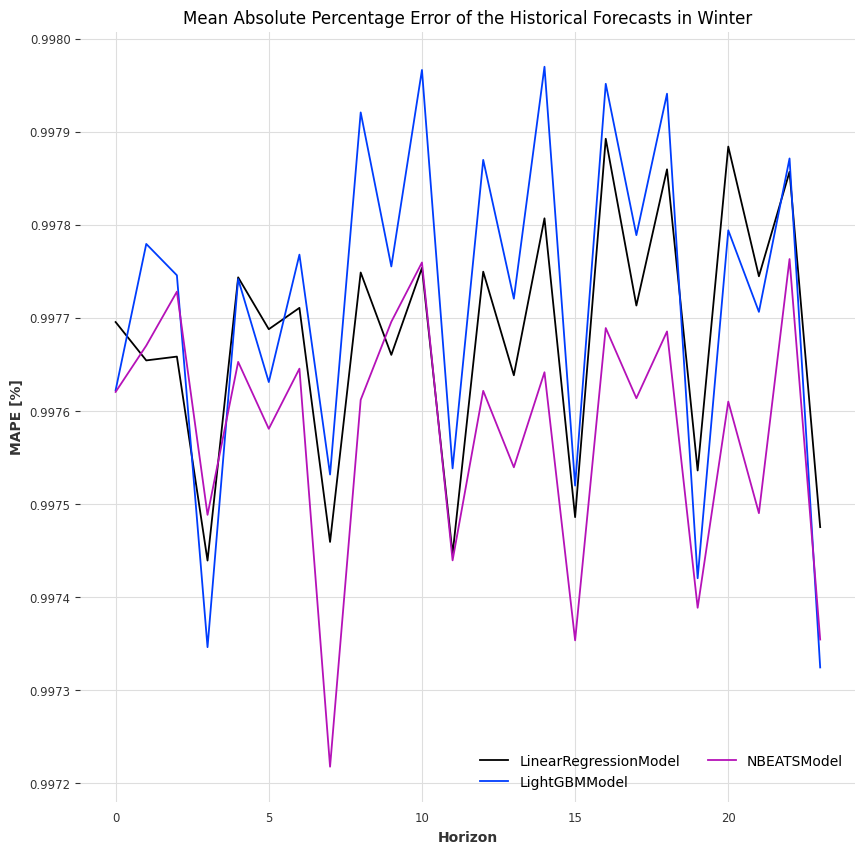

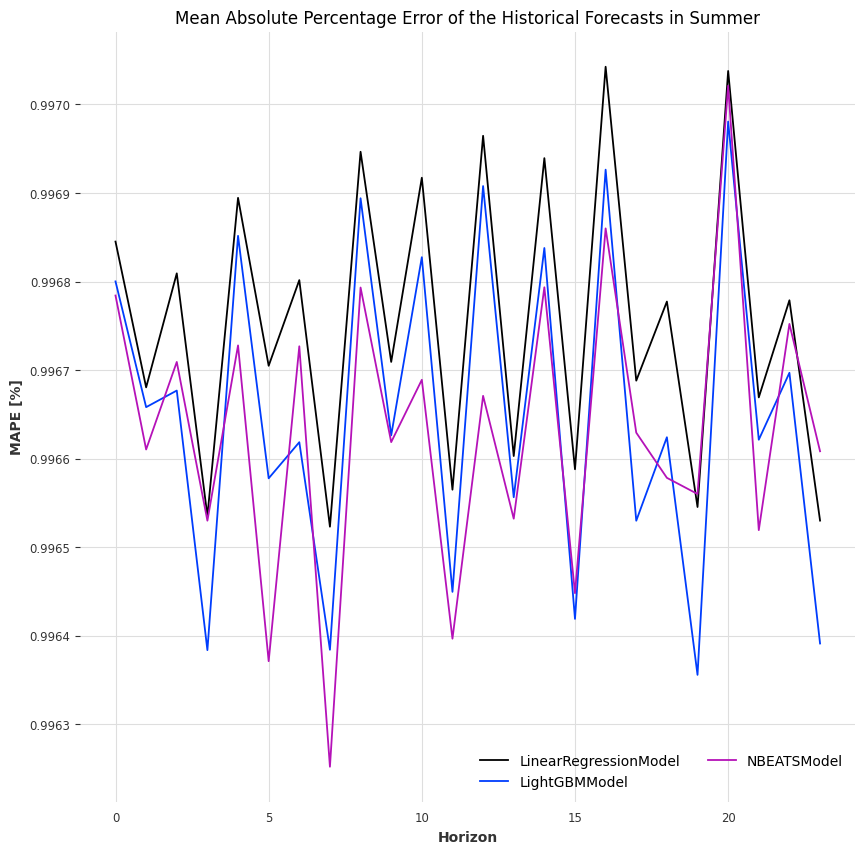

In [48]:
for season in dict_result_season.keys():
    fig = df_smapes_per_season[season].plot(figsize=(10,10))
    plt.xlabel('Horizon')
    plt.ylabel('MAPE [%]')
    plt.legend(loc = 'lower right', ncol = 2)
    plt.title(f"Mean Absolute Percentage Error of the Historical Forecasts in {season}")
    wandb.log({f"MAPE of the Historical Forecasts in {season}": wandb.Image(fig)})


### Plot 3: Error distribution

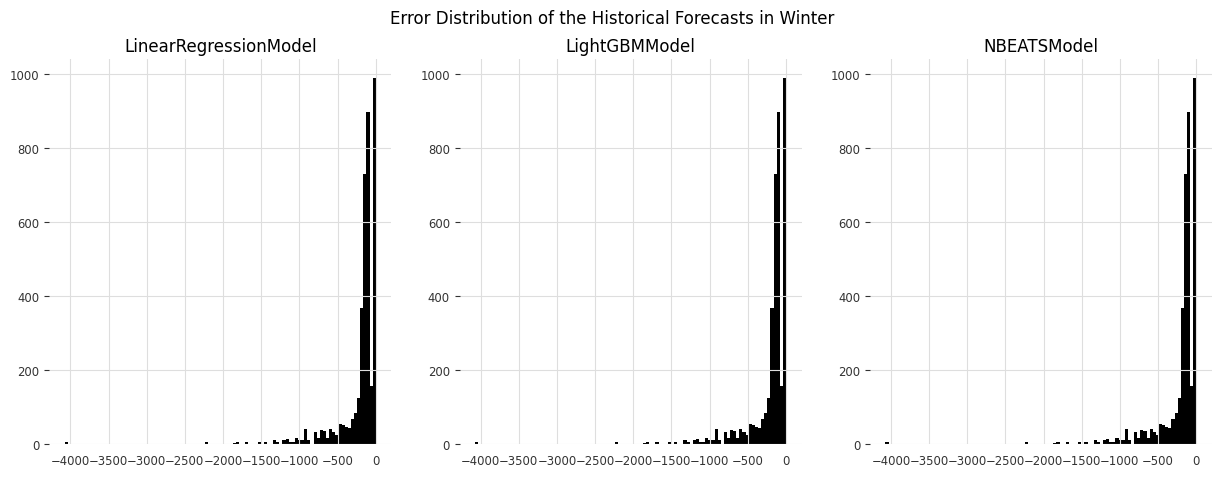

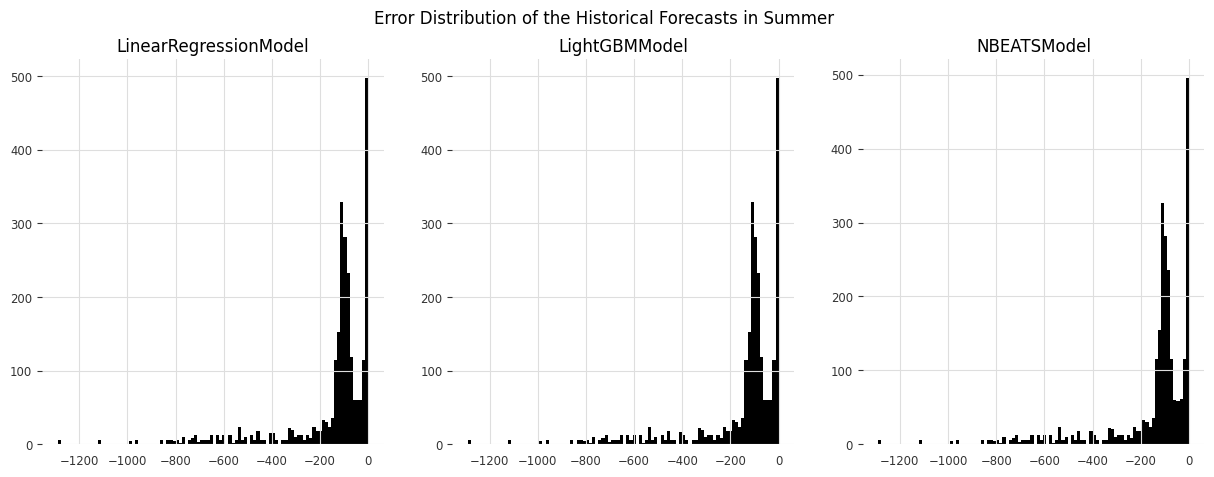

In [58]:
for season, (historics_per_model, _, gt) in dict_result_season.items():
    df_smapes_per_model = []
    df_nrmse_per_model = []
    if len(model_names) < 4:
        fig, ax = plt.subplots(ncols=len(model_names), figsize=(5*len(model_names),5))
    else:
        n_rows = len(model_names) // 4
        n_cols = len(model_names) // n_rows
        fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(20,10))
    fig.suptitle(f"Error Distribution of the Historical Forecasts in {season}")
    for i, (model_name, historics) in enumerate(historics_per_model.items()):
        df_list = get_df_compares_list(historics, gt)
        diffs = get_df_diffs(df_list)
        diffs_flat = pd.Series(diffs.values.reshape(-1,))
        ax[i].hist(diffs_flat, bins=100)
        ax[i].set_title(model_name)
    
    wandb.log({f"Error Distribution of the Historical Forecasts in {season}": wandb.Image(fig)})
    plt.show()



### Plot 4: Per Day

In [ ]:
for season, (_, preds_per_model, gt) in dict_result_season.items():
    for model_name, preds in preds_per_model.items():

        df_compare = pd.concat([preds.pd_series(), gt.pd_series()], axis=1).dropna()
        df_compare.columns = ["preds", "gt"]
        df_compare.groupby(df_compare.index.day).mean().plot(figsize=(10,10))

        

        